<!--NOTEBOOK_HEADER-->
*This notebook contains material from the [ND-Pyomo-Cookbook](https://jckantor.github.io/ND-Pyomo-Cookbook) by
Jeffrey Kantor (jeff at nd.edu); the content is available [on Github](https://github.com/jckantor/ND-Pyomo-Cookbook.git).
*The text is released under the [CC-BY-NC-ND-4.0 license](https://creativecommons.org/licenses/by-nc-nd/4.0/legalcode),
and code is released under the [MIT license](https://opensource.org/licenses/MIT).*

<!--NAVIGATION-->
< [Differential-Algebraic Equations](http://nbviewer.jupyter.org/github/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/06.00-Differential-Algebraic-Equations.ipynb) | [Contents](toc.ipynb) | [Index](index.ipynb) | [Maximizing Concentration of an Intermediate in a Batch Reactor](http://nbviewer.jupyter.org/github/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/06.02-Maximizing-Concentration-of-an-Intermediate-in-a-Batch-Reactor.ipynb) ><p><a href="https://colab.research.google.com/github/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/06.01-Unconstrained-Scalar-Optimization.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a>

# Unconstrained Scalar Optimization

Introductory calculus courses introduce the minimization (or maximization) of a function of a single variable. Given a function $f(x)$, find values $x^*$ such that $f(x^*) \leq f(x)$ (or $f(x^*) \geq f(x)$) for all $x$ in an interval containing $x^*$. Such points are called local optima. 

If the derivative exists at all points in a given interval, then the local optima are found by solving for values $x^*$ that satisfy

\begin{align}
f'(x^*) = 0
\end{align}

Let's see how this is put to work in the context of process engineering.

## Imports

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

import shutil
import sys
import os.path

if not shutil.which("pyomo"):
    !pip install -q pyomo
    assert(shutil.which("pyomo"))

if not (shutil.which("ipopt") or os.path.isfile("ipopt")):
    if "google.colab" in sys.modules:
        !wget -N -q "https://ampl.com/dl/open/ipopt/ipopt-linux64.zip"
        !unzip -o -q ipopt-linux64
    else:
        try:
            !conda install -c conda-forge ipopt 
        except:
            pass

assert(shutil.which("ipopt") or os.path.isfile("ipopt"))
from pyomo.environ import *

## Application: Maximizing production of a reaction intermediate

A desired product $B$ is produced as intermediate in a series reaction

\begin{align}
A \overset{k_A}{\longrightarrow} B \overset{k_B}{\longrightarrow} C
\end{align}

where $A$ is a raw material and $C$ is a undesired by-product. The reaction operates at temperature where the rate constants are $k_A = 0.5\ \mbox{min}^{-1}$ and $k_A = 0.1\ \mbox{min}^{-1}$. The raw material is available as a solution with concenration $C_{A,f} = 2.0\ \mbox{moles/liter}$.

A 100 liter tank is avialable to run the reaction. Below we will answer the following questions:

1. If the goal is obtain the maximum possible concentration of $B$, and the tank is operated as a continuous stirred tank reactor, what should be the flowrate? 

2. What is the production rate of $B$ at maximum concentration?

## Mathematical model for a continuous stirred tank reactor

The reaction dynamics for an isothermal continuous stirred tank reactor with a volume $V = 40$ liters and feed concentration $C_{A,f}$ are modeled as

\begin{align}
V\frac{dC_A}{dt} & = q(C_{A,f} - C_A) - V k_A C_A \\
V\frac{dC_B}{dt} & = - q C_B + V k_A C_A - V k_B C_B
\end{align}

At steady-state the material balances become

\begin{align}
0 & = q(C_{A,f} - \bar{C}_A) - V k_A \bar{C}_A \\
0 & = - q \bar{C}_B + V k_A \bar{C}_A - V k_B \bar{C}_B 
\end{align}

which can be solved for $C_A$

\begin{align}
\bar{C}_A & = \frac{qC_{A,f}}{q + Vk_A} \\
\end{align}

and then for $C_B$

\begin{align}
\bar{C}_B & = \frac{q V k_A C_{A,f}}{(q + V k_A)(q + Vk_B)}
\end{align}

The numerator is first-order in flowrate $q$, and the denominator is quadratic.  This is consistent with an intermediate value of $q$ corresponding to a maximum concentration $\bar{C}_B$. 

The next cell plots $\bar{C}_B$ as a function of flowrate $q$.

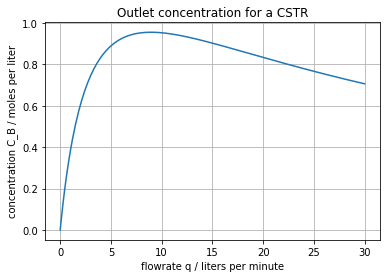

In [5]:
V = 40     # liters
kA = 0.5   # 1/min
kB = 0.1   # l/min
CAf = 2.0  # moles/liter

def cstr(q):
    return q*V*kA*CAf/(q + V*kB)/(q + V*kA)

q = np.linspace(0,30,200)
plt.plot(q, cstr(q))
plt.xlabel('flowrate q / liters per minute')
plt.ylabel('concentration C_B / moles per liter')
plt.title('Outlet concentration for a CSTR')
plt.grid(True)

We see that, for the parameters given, there is an optimal flowrate somewhere between 5 and 10 liters per minute.

## Analytical solution using calculus

As it happens, this problem has an interesting analytical solution that can be found by hand, and which can be used to check the accuracy of numerical solutions. Setting the first derivative of $\bar{C}_B$ to zero,

\begin{align}
\left.\frac{d\bar{C}_B}{dq}\right|_{q^*} = \frac{V k_A C_{A,f}}{(q^* + V k_A)(q^* + Vk_B)} - \frac{q^* V k_A C_{A,f}}{(q^* + V k_A)^2(q^* + Vk_B)} - \frac{q^* V k_A C_{A,f}}{(q^* + V k_A)(q^* + Vk_B)^2} = 0
\end{align}

Clearing out the non-negative common factors yields

\begin{align}
1 - \frac{q^*}{(q^* + V k_A)} - \frac{q^*}{(q^* + Vk_B)} = 0
\end{align}

and multiplying by the non-negative denominators produces

\begin{align}
{q^*}^2 + q^*V(k_A + k_B) + V^2k_Ak_B - q^*(q^* + Vk_B) - q^*(q^* + Vk_A) = 0
\end{align}

Expanding these expressions followed by arithmetic cancelations gives the final result

\begin{align}
q^*  =  V\sqrt{k_Ak_B}
\end{align}

which shows the optimal dilution rate, $\frac{q^*}{V}$, is equal the geomtric mean of the rate constants.

In [6]:
V = 40     # liters
kA = 0.5   # 1/min
kB = 0.1   # l/min
CAf = 2.0  # moles/liter

qmax = V*np.sqrt(kA*kB)
CBmax = cstr(qmax)
print('Flowrate at maximum CB = ', qmax, 'liters per minute.')
print('Maximum CB =', CBmax, 'moles per liter.')
print('Productivity = ', qmax*CBmax, 'moles per minute.')

Flowrate at maximum CB =  8.94427190999916 liters per minute.
Maximum CB = 0.9549150281252629 moles per liter.
Productivity =  8.541019662496845 moles per minute.


## Numerical solution with Pyomo

This problem can also be solved using Pyomo to create a model instance. First we make sure that Pyomo and ipopt are installed, then we proceed with the model specification and solution.

In [8]:
V = 40     # liters
kA = 0.5   # 1/min
kB = 0.1   # l/min
CAf = 2.0  # moles/liter

# create a model instance
m = ConcreteModel()

# create the decision variable
m.q = Var(domain=NonNegativeReals)

# create the objective
m.CBmax = Objective(expr=m.q*V*kA*CAf/(m.q + V*kB)/(m.q + V*kA), sense=maximize)

# solve using the nonlinear solver ipopt
SolverFactory('ipopt').solve(m)

# print solution
print('Flowrate at maximum CB = ', m.q(), 'liters per minute.')
print('Maximum CB =', m.CBmax(), 'moles per liter.')
print('Productivity = ', m.q()*m.CBmax(), 'moles per minute.')

Flowrate at maximum CB =  8.944271964904422 liters per minute.
Maximum CB = 0.9549150281252627 moles per liter.
Productivity =  8.541019714926705 moles per minute.


One advantage of using Pyomo for solving problems like these is that you can reduce the amount of algebra needed to prepare the problem for numerical solution. This not only minimizes your work, but also reduces possible sources of error in your solution.

In this example, the steady-state equations are

\begin{align}
0 & = q(C_{A,f} - \bar{C}_A) - V k_A \bar{C}_A \\
0 & = - q \bar{C}_B + V k_A \bar{C}_A - V k_B \bar{C}_B 
\end{align}

with unknowns $C_B$ and $C_A$. The modeling strategy is to introduce variables for the flowrate $q$ and these unknowns, and introduce the steady state equations as constraints.

In [9]:
V = 40     # liters
kA = 0.5   # 1/min
kB = 0.1   # l/min
CAf = 2.0  # moles/liter

# create a model instance
m = ConcreteModel()

# create the decision variable
m.q  = Var(domain=NonNegativeReals)
m.CA = Var(domain=NonNegativeReals)
m.CB = Var(domain=NonNegativeReals)

# equations as constraints
m.eqn = ConstraintList()
m.eqn.add(0 == m.q*(CAf - m.CA) - V*kA*m.CA)
m.eqn.add(0 == -m.q*m.CB + V*kA*m.CA - V*kB*m.CB)

# create the objective
m.CBmax = Objective(expr=m.CB, sense=maximize)

# solve using the nonlinear solver ipopt
SolverFactory('ipopt').solve(m)

# print solution
print('Flowrate at maximum CB = ', m.q(), 'liters per minute.')
print('Maximum CB =', m.CBmax(), 'moles per liter.')
print('Productivity = ', m.q()*m.CBmax(), 'moles per minute.')

Flowrate at maximum CB =  8.944272002876572 liters per minute.
Maximum CB = 0.9549150281377387 moles per liter.
Productivity =  8.54101975129847 moles per minute.


<!--NAVIGATION-->
< [Differential-Algebraic Equations](http://nbviewer.jupyter.org/github/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/06.00-Differential-Algebraic-Equations.ipynb) | [Contents](toc.ipynb) | [Index](index.ipynb) | [Maximizing Concentration of an Intermediate in a Batch Reactor](http://nbviewer.jupyter.org/github/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/06.02-Maximizing-Concentration-of-an-Intermediate-in-a-Batch-Reactor.ipynb) ><p><a href="https://colab.research.google.com/github/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/06.01-Unconstrained-Scalar-Optimization.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a>